# Machine Learning Explainability
## **Extract human-understandable insights from any model.**

Link to the course: https://www.kaggle.com/learn/machine-learning-explainability?rvi=1

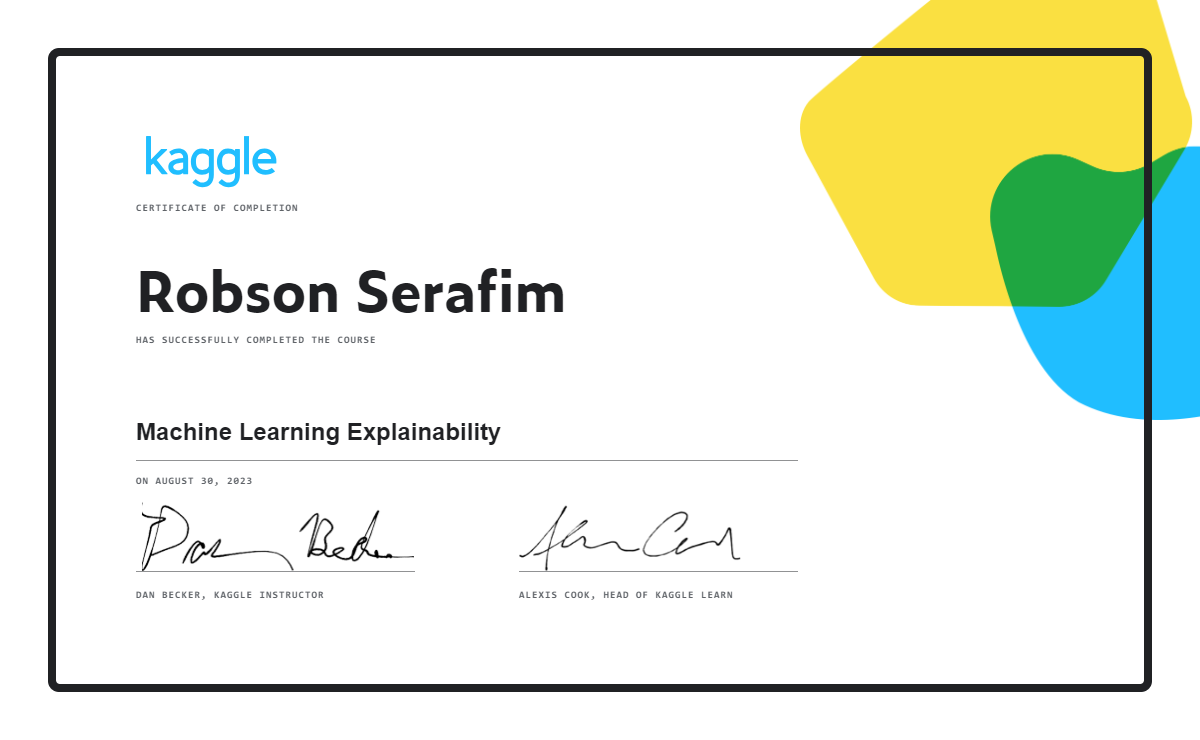

# **1. Use Cases for Model Insights**


## **1.1 What Types of Insights Are Possible**

Many people say machine learning models are "black boxes", in the sense that they can make good predictions but you can't understand the logic behind those predictions. This statement is true in the sense that most data scientists don't know how to extract insights from models yet.

However, this micro-course will teach you techniques to extract the following insights from sophisticated machine learning models.

- What features in the data did the model think are most important?
- For any single prediction from a model, how did each feature in the data affect that particular prediction?
- How does each feature affect the model's predictions in a big-picture sense (what is its typical effect when considered over a large number of possible predictions)?

## **1.2 Why Are These Insights Valuable**
These insights have many uses, including:

- Debugging
- Informing feature engineering
- Directing future data collection
- Informing human decision-making
- Building Trust

# **2. Permutation Importance**:

Compared to most other approaches of **feature importance, permutation importance** is:

- fast to calculate,
- widely used and understood, and
- consistent with properties we would want a feature importance measure to have.

## **2.1 Basic concepts:**

Main idea: The central idea behind Permutation Importance is to evaluate how the model's performance deteriorates when the order of a feature's values is randomly shuffled. The more the performance drops after shuffling, the higher the importance of the feature.

Steps:

- Initial Training: First, the model is trained using the original training data and performance (such as accuracy, F1-score, etc.) is recorded.
- Permutation: For each feature, its values are randomly shuffled between the test samples, leaving the other features unchanged.
- Evaluation: The model is again used to make predictions using the data with the shuffled feature, and the performance is calculated.
Importance: The difference between the original performance and the performance with the shuffled feature is used as a measure of the importance of that feature.

**The greater the difference, the greater the importance.**

## **2.2 Code Example**:

Our example will use a model that predicts whether a soccer/football team will have the **"Man of the Game" winner** based on the team's statistics. The "Man of the Game" award is given to the best player in the game.

Model-building isn't our current focus, so the cell below loads the data and builds a rudimentary model

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('/content/drive/MyDrive/Data_Science_studies/Kaggle - ML Explainability/data/FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0).fit(train_X, train_y)

In [ ]:
pip install eli5

In [4]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, scoring='accuracy', random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names=val_X.columns.tolist())

Weight,Feature
0.1750 ± 0.0848,Goal Scored
0.0500 ± 0.0637,Distance Covered (Kms)
0.0437 ± 0.0637,Yellow Card
0.0187 ± 0.0500,Off-Target
0.0187 ± 0.0637,Free Kicks
0.0187 ± 0.0637,Fouls Committed
0.0125 ± 0.0637,Pass Accuracy %
0.0125 ± 0.0306,Blocked
0.0063 ± 0.0612,Saves
0.0063 ± 0.0250,Ball Possession %


**Interpreting Permutation Importance:**

- Values **closer to the top are the most important features**, while values closer to the bottom are of less importance.

- The first number in each row shows how much the model's performance decreased with random mixing (in this case, using "accuracy" as the performance metric).

- As with most things in data science, there is some randomness in the exact change in performance when mixing a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with several mixtures. The number after the ± measures how the performance varied from one mix to the next.

- Occasionally, you will see negative values for the permutation importances. In these cases, the predictions on the scrambled (or noisy) data turned out to be more accurate than on the real data. This happens when the feature didn't matter (it should have an importance close to 0), but chance made the predictions in the shuffled data more accurate. This is more common in small data sets, like the one in this example, because there is more scope for luck/chance.

- In our example, the most important characteristic was **"Goals scored".** This seems sensible. Soccer fans may have some intuition about whether the orders of the other variables are surprising or not.

# **3. Partial Plots**: How does each feature affect your predictions?

Partial Plots show how a feature affects predictions.

This is useful for answering questions such as:

- Controlling for all the other characteristics of the houses, what is the impact of longitude and latitude on house prices? In other words, what would the price of similar-sized houses in different areas be like?

- Are the predicted health differences between two groups due to differences in their diets or some other factor?

If you are familiar with linear or logistic regression models, partial dependency graphs can be interpreted in a similar way to the coefficients in these models. However, partial dependence graphs in sophisticated models can capture more complex patterns than the coefficients of simple models.

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv('/content/drive/MyDrive/Data_Science_studies/Kaggle - ML Explainability/data/FIFA 2018 Statistics.csv')

y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

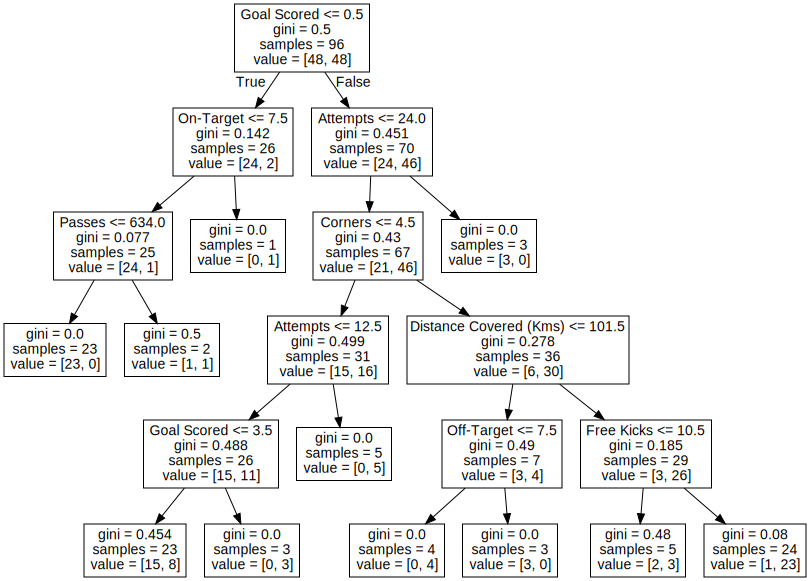

In [20]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)

As a guide to reading the Decision Tree:

- The leaves with children show their splitting criteria at the top
- The pair of values at the bottom shows the count of false values and true values for the target, respectively, of the data points in that node of the tree.

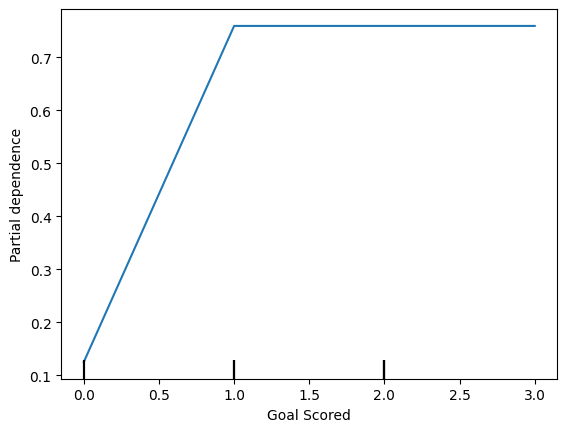

In [7]:
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Create and plot the data
disp1 = PartialDependenceDisplay.from_estimator(tree_model, val_X, ['Goal Scored'])
plt.show()

- The y-axis is interpreted as the change in prediction compared to what would have been predicted in the baseline or leftmost value.

- In this particular graph, we see that scoring a goal substantially increases your chances of winning the "Man of the Match" award. But extra goals beyond that seem to have little impact on the predictions

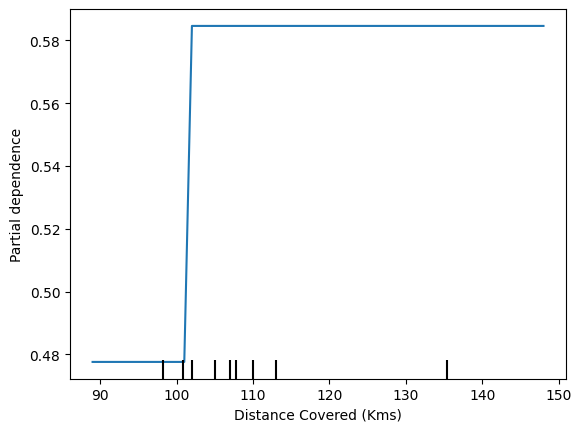

In [8]:
feature_to_plot = 'Distance Covered (Kms)'
disp2 = PartialDependenceDisplay.from_estimator(tree_model, val_X, [feature_to_plot])
plt.show()

This graph looks too simple to represent reality. But that's because the model is so simple. You should be able to see from the decision tree above that this exactly represents the structure of the model.

You can easily compare the structure or implications of different models. Here is the same graph with a Random Forest mode

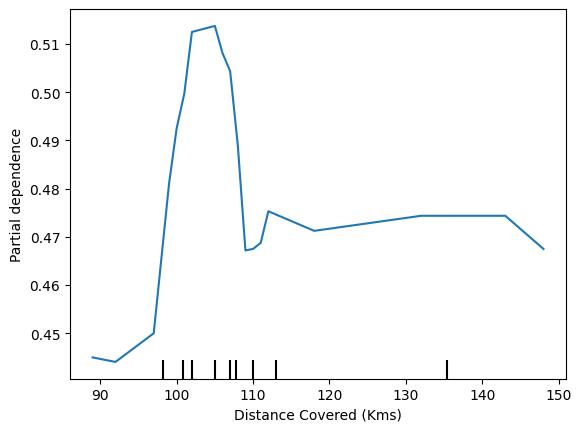

In [9]:
# Build Random Forest model
rf_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

disp3 = PartialDependenceDisplay.from_estimator(rf_model, val_X, [feature_to_plot])
plt.show()

This model believes that you have a **better chance of winning the Man of the Match award if your players run a total of 100 km over the course of the game.** Although running much more causes lower predictions.

In general, the smooth shape of this curve seems more plausible than the step function of the decision tree model. Although this data set is small enough for us to be careful when interpreting any model.

### **3.1 2D Partial Dependence Plots**:

If you're curious about the interactions between resources, 2D partial dependency graphs are also useful. An example can clarify this.

We'll use the decision tree model again for this graph. It will create an extremely simple graph, but you should be able to match what you see in the graph with the tree itself.

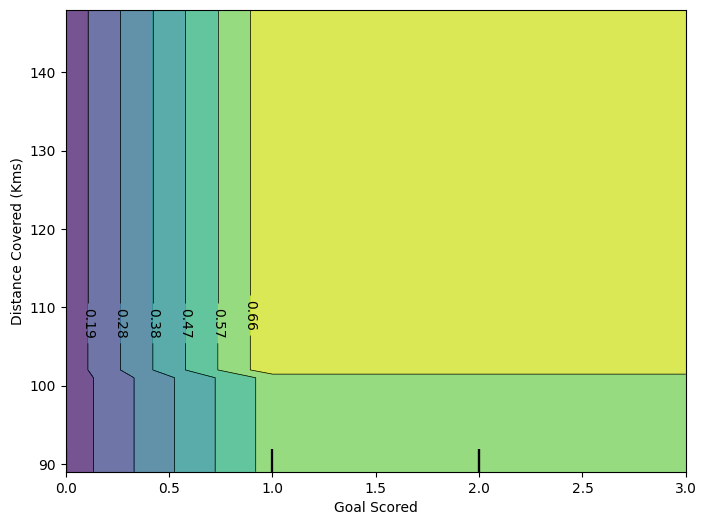

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
f_names = [('Goal Scored', 'Distance Covered (Kms)')]

# Similar to previous PDP plot except we use tuple of features instead of single feature

disp4 = PartialDependenceDisplay.from_estimator(tree_model, val_X, f_names, ax=ax)
plt.show()

This graph shows the predictions for any combination of goals scored and distance traveled.

- For example, we see the highest predictions when a team scores at least 1 goal and travels a total distance close to 100 km. If they score 0 goals, the distance traveled doesn't matter. You can see this by running through the decision tree with 0 goals?

- But the distance can affect the predictions if they score goals. Make sure you can see this in the 2D partial dependency graph. Can you see this pattern in the decision tree too?

# **4. SHAP Values:** Understand individual predictions

You've already seen (and used) techniques for extracting general insights from a machine learning model. But what if you want to drill down into how the model works for an individual forecast?

SHAP values (an acronym for SHapley Additive exPlanations) drill down into a forecast to show the impact of each feature. Where could you use this?

- A model says that a bank should not lend money to someone, and the bank is legally obliged to explain the basis for each loan rejection
- A healthcare provider wants to identify which factors are determining each patient's risk of disease, so that they can directly address these risk factors with targeted healthcare interventions.


You will use SHAP values to explain individual predictions in this lesson. In the next lesson, you'll see how they can be aggregated into powerful insights at the model level.

## **4.1 How do they work?**

SHAP values interpret the impact of having a certain value for a given feature **compared to the prediction we would make if that feature had some baseline value.

In these tutorials, we predicted whether a player on a team would win the best player of the match award.

We might ask ourselves:

- To what extent was the prediction motivated by the fact that the team scored 3 goals?

But it's easier to give a concrete, numerical answer if we rephrase the question as:

- **How much was the prediction motivated by the fact that the team scored 3 goals, rather than a basic number of goals?**.

Of course, each team has many variables. So if we answer this question for the number of goals, we can repeat the process for all the other variables.


SHAP values do this in a way that guarantees good ownership. Specifically, you break down a prediction with the following equation:

**sum(SHAP values for all features) = pred_for_team - pred_for_baseline_values**


In other words, the SHAP values of all the features add up to explain why my prediction was different from the baseline. This allows us to break down a prediction into a graph like this:

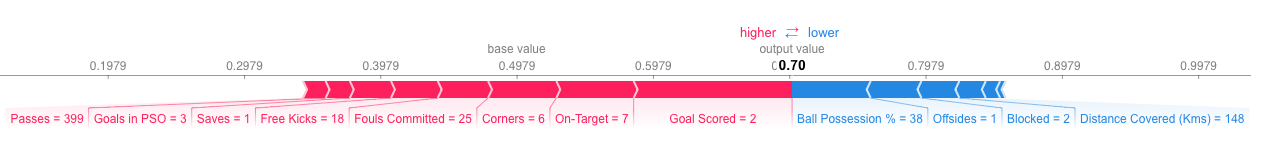

**How do you interpret this?**

We predicted 0.7, while the base_value is 0.4979.

The values of the features that **cause an increase in predictions are in pink, and their visual size shows the magnitude of the feature's effect. The values of the features that decrease the prediction are in blue.** The biggest impact comes from the fact that the goal scored is 2. Although the possession value has a significant effect on decreasing the prediction.

If you subtract the length of the blue bars from the length of the pink bars, this equals the distance from the base value to the result.

The technique is a little complex to ensure that the baseline plus the sum of the individual effects add up to the prediction (which is not as simple as it sounds).

**We will examine the SHAP values of a single row in the data set (we have arbitrarily chosen row 5). For context, we'll look at the raw predictions before examining the SHAP values.**

In [16]:
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [17]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


my_model.predict_proba(data_for_prediction_array)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[0.29, 0.71]])

The team has a 71% probability that one player will win the prize.

Now, let's move on to the code for obtaining SHAP values for this single prediction.

In [ ]:
pip install shap

In [18]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

The shap_values object above is a list with two arrays:

- The first array is the SHAP values for a negative outcome (not winning the prize) and the second array is the list of SHAP values for the positive outcome (winning the prize).
- We usually think of predictions in terms of predicting a positive outcome, so we'll extract the SHAP values for positive outcomes (by extracting shap_values[1]).

It's complicated to analyze raw matrices, but the shap package has a good way of visualizing the results:

In [19]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

**Chart Components

- Base Value: This is the value that would be predicted if we had no specific information. It is usually the average of the predictions for all the observations in the data set.

- Output Value: This is the forecast value for the specific observation you are analyzing.

- Features: Each feature that affects the forecast is listed as a bar in the graph.

**Colors and Directions**
- Blue bars: These indicate that the feature in question is reducing the forecast. In the context of your model, this means that the feature is reducing the probability of the team being the "Man of the Match".

- Pink bars: Indicate that the characteristic is increasing the prediction. In other words, these characteristics make it more likely that the team will be Man of the Match.

**Size of Bars**
The size of the bar represents the size of the effect. A larger bar (in absolute value) has a greater impact on the prediction.

**Higher and Lower**
- Higher: This side of the graph shows the characteristics that are contributing to increasing the prediction, i.e. making it more likely that the team will be the "Man of the Match" (in this context). These are usually the pink bars.

- Lower: This side shows the characteristics that are contributing to lowering the prediction. That is, making it less likely that the team will be the "Man of the Match". These are usually the blue bars.

- **f(x) and 0.71:**
  - f(x): This is the value of the prediction for the specific observation. In the context of your model, this is the value that the model predicted for the probability of the team being the "Man of the Match".

  - 0.71: This is the numerical value of the prediction. In your case, the model is predicting with a 71% probability that the team will be Man of the Match.

The point where these two forces meet (Higher and Lower) represents the balance of the positive and negative influences of the characteristics. This "meeting point" is essentially the final prediction made by the model for this specific observation, which is the value of f(x) or 0.71 in this case.


**Interpretation**
- You can see which characteristics are the most influential in the forecast by looking at the longer bars.

- The features are ranked in order of importance, from most influential to least influential.

The SHAP force graph is a way of "opening the black box" of machine learning models and understanding the reasoning behind a specific prediction.





# **5. Advanced uses of SHAP Values:** Aggregate SHAP values for even more detailed model insights

Now let's expand the SHAP values, seeing how aggregating many SHAP values can offer more detailed alternatives to **permutation importance and partial dependence plots.**

## 5.1 Shap Summary Plots

**Permutattion Importance** is excellent because it creates simple numerical measures to see which features are important to a model. This has helped us to make comparisons between features easily, and you can present the resulting graphs to non-technical audiences.

But it doesn't tell you how important each feature is:
- If a feature has medium permutation importance, it could mean that it has a large effect for some predictions, but no effect overall, or
an average effect for all predictions.

- SHAP summary plots give us an overview of the importance of the feature and what is determining it.

Let's look at an example plot for soccer data:

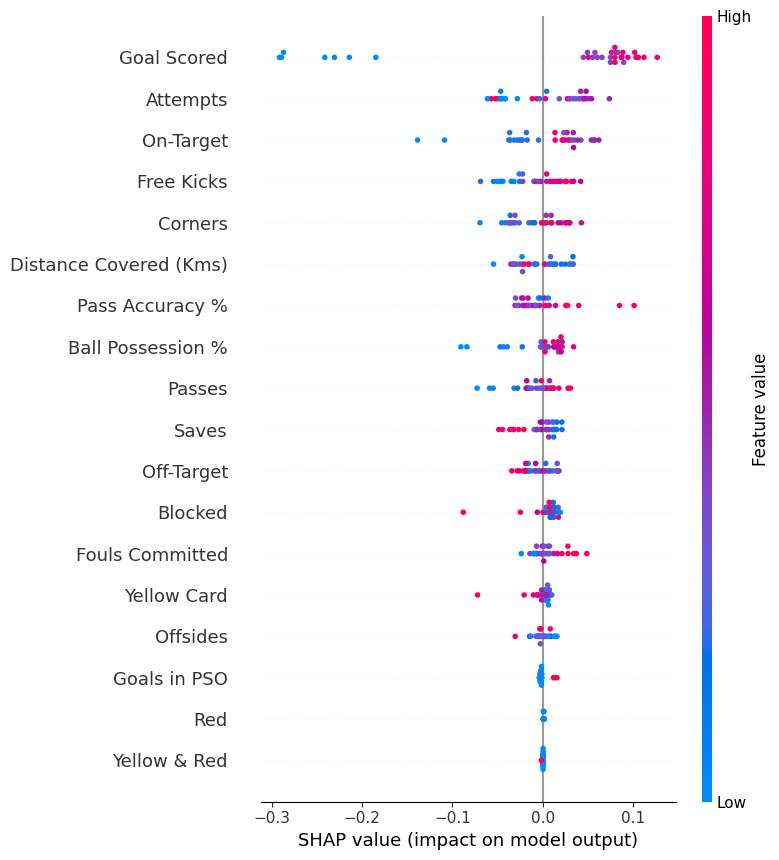

In [23]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.

# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X)

This graph is made up of many points. Each point has three characteristics:

- The vertical location **shows the feature** that is being represented;

- The color shows whether the **value of that feature was high or low** for that row of the data set;

- The horizontal location **shows whether the effect of this value caused a higher or lower prediction**.

For example, the dot in the top left corner was for a team that scored few goals, reducing the prediction by 0.25.

There are a few things you should be able to **identify easily:**

- The model ignored the Red and Yellow and Red features;

- Normally, the yellow card doesn't affect the prediction, but there is an extreme case where a high value caused a much lower prediction.

- High Scored Goal values caused higher predictions, and low values caused low predictions

If you look long enough, there is a lot of information in this graph.

--------------------------------------------------------------------------------

**Important note**

Do you think that the range of effect sizes (distance between the smallest effect and the largest effect) is a good indication of which feature will have the greatest permutation importance? Why or why not?

**If the range of effect sizes measures something other than permutation importance**: what is the best answer to the question "Which of these two features does the model say is more important for us to understand when discussing readmission risks in the population?" Solution: No. The width of the range is a good indication of which feature will have greater permutation importance?

Solution: No. The width of the range of effects is not a reasonable approximation of the importance of permutation. Furthermore, the width of the range does not map well onto any intuitive sense of "importance", as it can be determined by just a few exceptions / outliers.

However, if all the points on the graph are very far apart, this is a reasonable indication that the importance of the permutation is high. As the range of effects is very sensitive to outliers, **permutation importance** is a better measure of what is generally important to the model.

--------------------------------------------------------------------------------

**About the code**

The code is not very complex. But there are a few caveats:

- When plotting, we call shap_values[1]. For classification problems, there is a separate matrix of SHAP values for each possible result. In this case, we index it to get the SHAP values for the "True" prediction;

- Calculating SHAP values can be slow. This is not a problem here, because this data set is small. But you should be careful when running them to plot with reasonably sized data sets. The **exception is when using an xgboost** model, for which SHAP has some optimizations and which is therefore much faster.

- This gives you an excellent overview of the model, but you may want to delve into a single feature. That's where SHAP Dependence Contribution Plots come into play.

## 5.2 SHAP Dependence Contribution Plots

We have previously used **Partial Dependence Plots** to show how a single feature affects predictions. These graphs are insightful and relevant to many real-world use cases. What's more, with a little effort, they can be explained to a non-technical audience.

But there are many things they don't show.

For example, what is the distribution of effects? Is the effect of having a certain value practically constant or does it vary greatly depending on the values of other resources?

SHAP dependency contribution graphs provide a similar view to PDPs, but add much more detail.

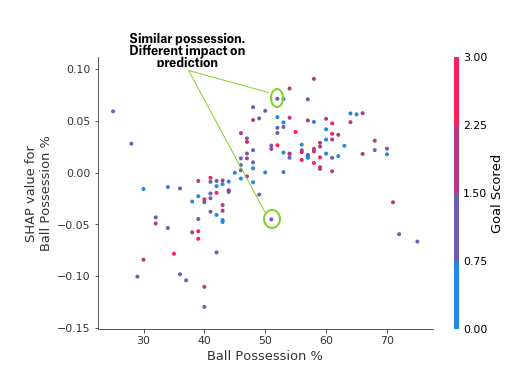

Each point represents a line of data. The horizontal location is the actual value of the data set, and the vertical location shows what having that value has impacted on the prediction. The fact that this slope is **ascending indicates that the more you have possession of the ball, the higher the model's prediction for winning the Man of the Match award.**

However, the dispersion suggests that other features must interact with the % of possession. For example, here we've highlighted **two points with similar possession values. This value caused one prediction to increase and the other to decrease.

This suggests that we delve deeper into the interactions, and the graphs include color coding to help do this. Although the main trend is upwards, you can visually inspect whether this varies according to the color of the point.

Consider the following very narrow example for the sake of concreteness:

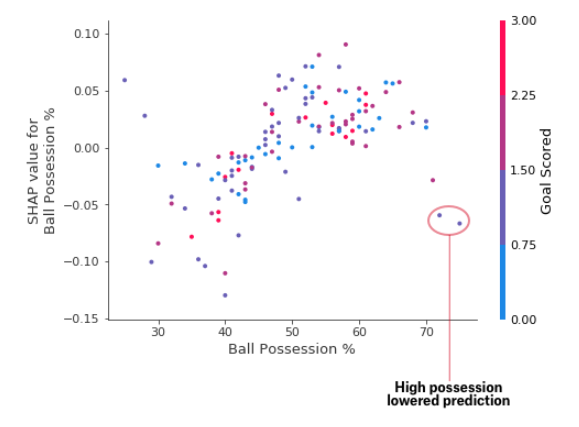

These two points stand out spatially because **they are far from the uptrend.** Both are purple, indicating that the team has scored a goal.

This can be interpreted as follows: **in general, having the ball increases the chance of a player from the team winning the award.** But if they only score one goal, this trend is reversed and the award judges may penalize them for having the ball so much and scoring so little.

Apart from these few outliers, the interaction indicated by the color is not very dramatic here.

**Dependence Contribution Plots in Code**:

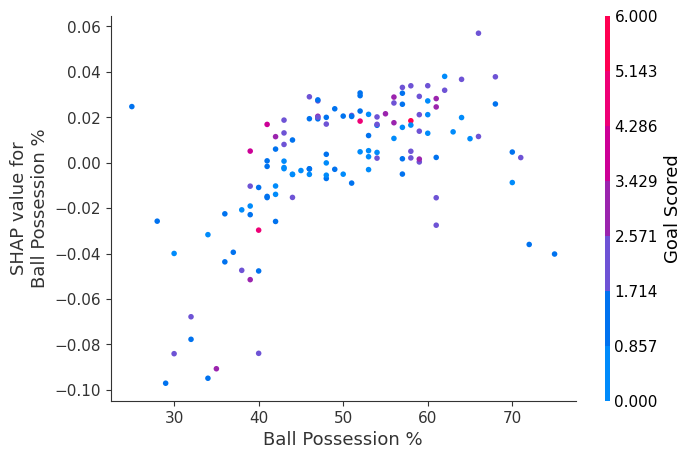

In [29]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X)

# make plot.
shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored") # você pode suprimir 'interaction_index' o Shape irá utilizar alguma lógica para retornar uma interação que poderá ser interessante.

# Conclusion

That's it! **Machine learning models should not feel like black boxes any more, because you have the tools to inspect them and understand what they learn about the world.**

This is an excellent skill for **debugging models, building trust, and learning insights to make better decisions.** These techniques have revolutionized how I do data science, and I hope they do the same for you.

Real data science involves an element of exploration. I hope you find an interesting dataset to try these techniques on!

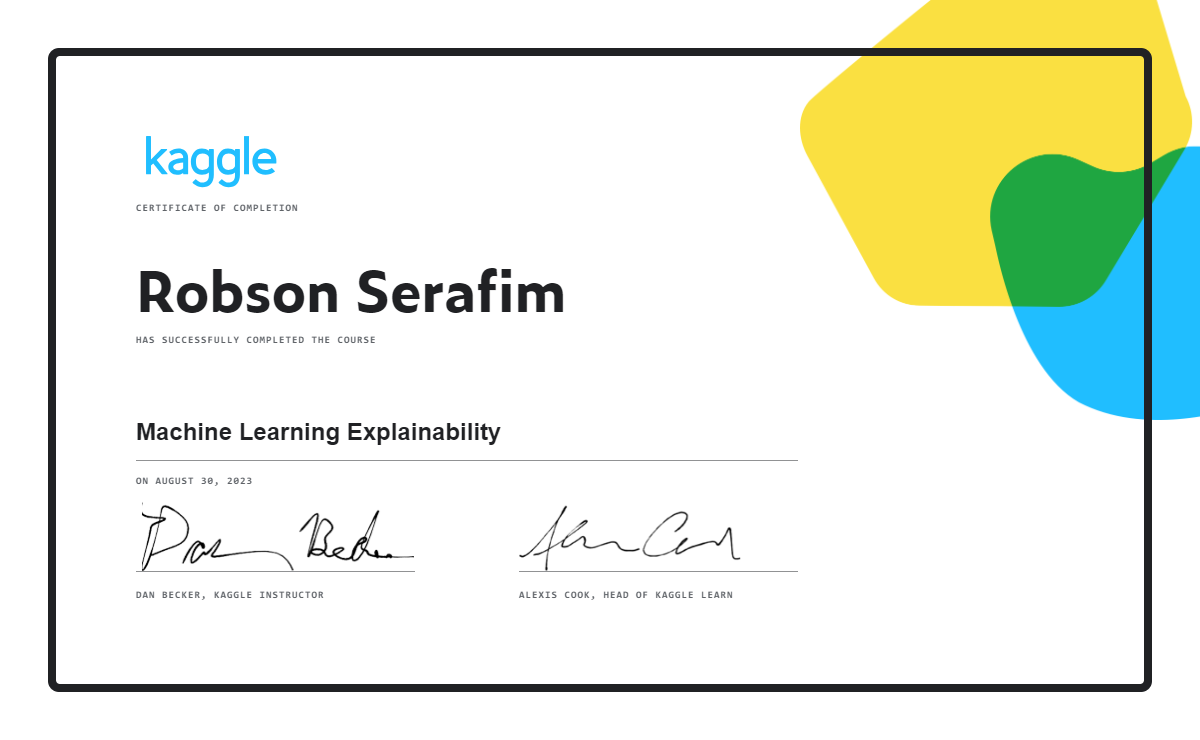